In [17]:
print("Hello World")

Hello World


In [18]:
import numpy as np
import matplotlib.pyplot as plt   
import pickle as pkl
from atasi import AtasiNet    
import os 
from pathlib import Path

In [19]:

WORK_DIR = os.path.join('../', Path().resolve())
DATA_DIR = os.path.join(WORK_DIR, 'Simulated_data')

fc = 14.25e9 #Hz
lambda_c = 0.021 #m
delta_D = 0.084 #m
R0 = 400 #m
theta = 45*np.pi/180 #rad
n_antennas = 8 #number of antennas
n_samples = 11 #number of samples
n_grids = 200 #number of grids (of different height cells)
max_height = 200 #m
run_W = False #run the W matrix calculation
rayleigh_res = lambda_c*R0/(2*delta_D) #Rayleigh resolution, 50m in this case 

In [20]:
def generate_backscatter_coefficients(height=None):
	if height == None : 
		height = np.random.choice([k for k in range(200)])
	A = min(max(np.abs(np.random.rayleigh(scale=2, size=1)[0]), 1), 4)

	phi = np.random.uniform(0, 2 * np.pi, size=1)[0]
	gamma_ = A * np.exp(1j * phi)
	gamma = np.zeros(n_grids,dtype=complex)
	gamma[height] = gamma_
	return gamma

#referred to as A in the model implementation part
def compute_measurement_matrix():
	s = np.linspace(0, max_height, n_grids) 
	#baselines in gamma-net go from -135 to 135 in 25 steps 
	baselines = np.linspace (-135,135,25)
	D = np.exp(1j * 4 * np.pi * np.outer(baselines, s) / (lambda_c * R0))
	return D

#ToDo : compute 11 levels of noise with SNR from 0 to 30 dB --> find the right gwn each time
def simulate_backscattered_signal(signal, D):
    return np.dot(D, signal)

def double_scatterer(height1,height2):
	gamma1 = generate_backscatter_coefficients(height1)
	gamma2 = generate_backscatter_coefficients(height2)
	gamma = gamma1 + gamma2 
	return [gamma,gamma1,gamma2]

def SNR(signal, noise):
	"""Computes the SNR of a signal
		inputs : 
			signal : the signal
			noise : the noise
		outputs :
			snr : the SNR of the signal
	"""
	signal_power = np.sum(np.abs(signal)**2)
	noise_power = np.sum(np.abs(noise)**2)
	snr = 10 * np.log10(signal_power / noise_power)
	return snr

def noise_for_snr(signal, snr):
	"""Adds the right amount of noise to the signal to reach the desired SNR 
		inputs : 
			signal : the signal to which the noise will be added
			snr : the desired SNR
		outputs :
			noisy_signal : the signal with added noise
	"""
	noise = np.random.normal(0, 1, signal.shape)
	signal_power = np.sum(np.abs(signal)**2)
	noise_power = np.sum(np.abs(noise)**2)
	noise = noise * np.sqrt(signal_power / (10**(snr/10) * noise_power))
	noisy_signal = signal + noise
	return noisy_signal

def generate_gamma(n_scatterers,height=None,scatterers_dist=None) :
	if n_scatterers == 2:

		#no height and resolution specified : generate random heights
		if height == None and scatterers_dist == None :
			height1 = np.random.choice([k for k in range(200)])
			height2 = np.random.choice([k for k in range(200)])
			while height1 == height2:
				height2 = np.random.choice([k for k in range(200)])

		#no height specified but resolution specified : generate random heights with a given distance
		elif height == None and scatterers_dist is not None :
			height1 = np.random.choice([k for k in range(200)])
			height2 = height1 + scatterers_dist 
			if height2 >= max_height : 
				height2 = height1 - scatterers_dist
		
		#height specified
		else : 
			height1 = height[0]
			height2 = height[1]

		return double_scatterer(height1,height2)
	
	elif n_scatterers == 1 : 
		if height is not None and type(height) != int : 
			raise TypeError("If only one scatterer, height must be an integer")
		elif height is None : 
			height = np.random.choice([k for k in range(200)])
		return [generate_backscatter_coefficients(height)]
	
	else : 
		raise ValueError("Number of scatterers must be one or two")
	
#if storage becomes an issue, we can change the way we store the data to avoid storing so many zeros
def generate_data(save=False,names=None):
	snr_values = np.linspace(0,30,11) #SNR values from 0 to 30 dB
	D = compute_measurement_matrix()
	
	#generate single scatterers' data
	single_scatterers = np.zeros(n_samples, dtype=dict)
	for snr in snr_values : 
		snr_index = np.where(snr_values == snr)[0][0]
		for i in range(n_samples//snr_values.shape[0]):
			gamma = generate_gamma(1)[0]
			signal = simulate_backscattered_signal(gamma, D)
			noisy_signal = noise_for_snr(signal, snr)
			#with gamma's modulus you can get A, with its phase you can get phi, with its index you can get the height
			#all the labels are in gamma
			data = {'signal':noisy_signal, 'gamma':gamma} 
			single_scatterers[snr_index * n_samples//snr_values.shape[0] + i] = data

	#generate double scatterers' data
	double_scatterers = np.zeros(n_samples, dtype=dict)
	for snr in snr_values : 
		snr_index = np.where(snr_values == snr)[0][0]
		for i in range(n_samples//snr_values.shape[0]):
			scatterers_gap = int(np.random.uniform(0.1, 1.2) * rayleigh_res)
			gamma,gamma1,gamma2 = generate_gamma(2,scatterers_dist=scatterers_gap)
			signal = simulate_backscattered_signal(gamma, D)
			noisy_signal = noise_for_snr(signal, snr)
			data = {'signal':noisy_signal, 'gamma':gamma, 'gamma1':gamma1, 'gamma2':gamma2, 'scatterers_gap':scatterers_gap} 
			double_scatterers[snr_index * n_samples//snr_values.shape[0] + i] = data

	if save :
		if names is None :
			names = ['single_scatterers','double_scatterers']
		np.save(os.path.join(DATA_DIR,names[0]), single_scatterers)
		np.save(os.path.join(DATA_DIR,names[1]), double_scatterers)
		
	return single_scatterers, double_scatterers


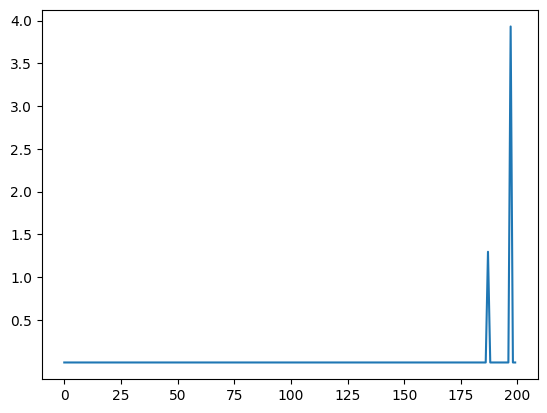

In [21]:
#plot the backscatter coefficients 

n_scatterers = 2
distancing_factor = 0.2 #between 0.1 and 1.2 (times the rayleigh resolution)

gamma = generate_gamma(n_scatterers,scatterers_dist=int(rayleigh_res*distancing_factor))[0]

plt.plot([np.abs(gamma[k]) for k in range(len(gamma))])
_ = plt.yticks([0.5,1,1.5,2,2.5,3,3.5,4])

(25, 200)
(25,)


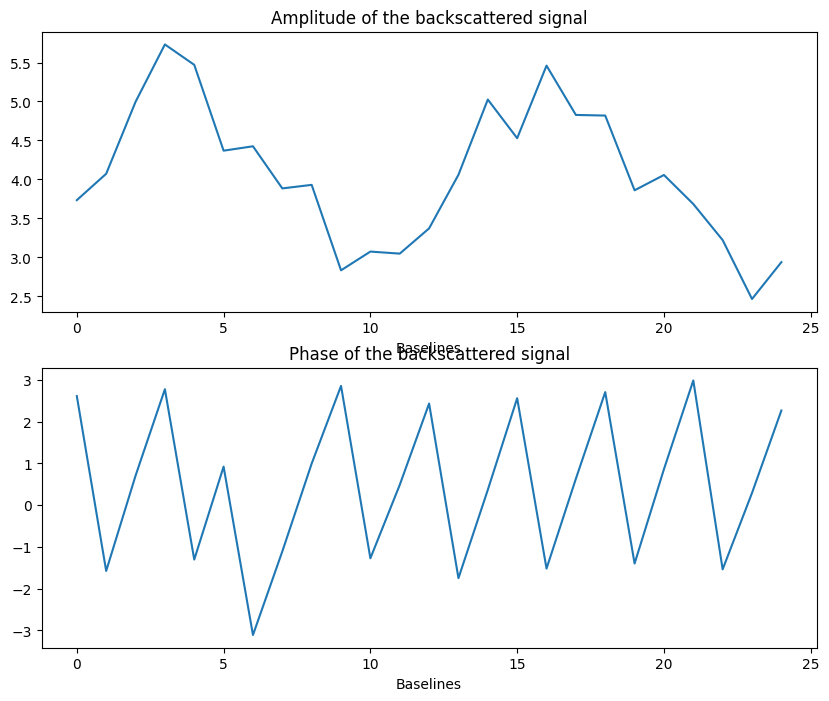

In [22]:
D = compute_measurement_matrix()
print(D.shape)

target_snr = 20

signal = noise_for_snr(gamma, target_snr)
y = simulate_backscattered_signal(signal,D)
print(y.shape)

f,axes = plt.subplots(2,1,figsize=(10,8))
axes[0].plot([np.abs(y[k]) for k in range(len(y))])
axes[1].plot([np.angle(y[k]) for k in range(len(y))])
axes[0].set_title("Amplitude of the backscattered signal")
axes[0].set_xlabel("Baselines")
axes[1].set_title("Phase of the backscattered signal")
axes[1].set_xlabel("Baselines")
plt.show()

In [23]:
if run_W:
	model = AtasiNet(D)
	W = model.compute_w()
	print(W.shape)
	print(D.shape)
	score = np.linalg.norm(W.T@D)**2
	print(score)
	pkl.dump(model, open("./Models/model_", "wb"))


In [24]:
generate_data(save=True)

(array([{'signal': array([ 5.09057391+2.47720068j, -4.85092021-1.32746837j,
                2.98692985+0.02526959j, -5.53610416+1.27983153j,
               -2.86705683-2.43793751j, -1.18499004+3.31603399j,
                4.36042947-3.81326713j,  2.99373155+3.87252719j,
                1.52992167-3.48700784j, 10.57026522+2.70098794j,
               -1.02563559-1.60474587j,  2.37675515+0.32419058j,
                0.21888632+0.99359963j, -1.90270011-2.19726989j,
                3.44454538+3.14857254j,  6.44380658-3.73824566j,
               -0.20443082+3.89856229j,  1.09141156-3.61110925j,
               -5.27134793+2.90890198j, -2.29914187-1.87259255j,
               -0.68799212+0.62120637j, -1.12026173+0.70152852j,
                0.87085963-1.9436893j , -2.01583952+2.9626075j ,
                6.75019161-3.64125518j]), 'gamma': array([ 0.        +0.j        ,  0.        +0.j        ,
                0.        +0.j        ,  0.        +0.j        ,
                0.        +0.j      

cristiano.ulondumendes@telecom-paris.fr